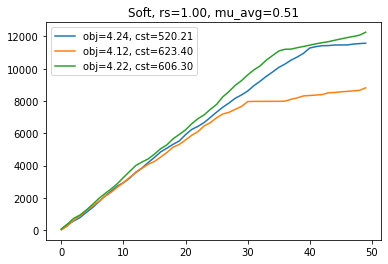

In [1]:
from functions import *


seed = 1
N = 3  # number of experiments
T = 50  # rounds per experiment
gamma = 10
rs = 1

np.random.seed(seed)

m = 20 # number of devices
n = 5  # number of servers

wD = np.random.randint(1 ,4 ,m )
wS = np.random.randint(1 ,4 ,n )

BD = np.random.uniform(50, 80, m)
BS = np.random.uniform(100, 300, n)
CD = np.random.uniform(100, 200, m)


def f(x, y, mu, gamma=1):
    return objective(x, y, mu, wD, wS, m, n, gamma)

# min f(x, y. mu)
def oracle(y, mu, gamma=0, hard=False):
    x, prob = optimization(m, n, wD, wS, y, mu, BD, BS, gamma, hard, CD=CD)
    return x.value, prob.value, prob.status


trace_gen = Trace(m, n, seed)
reg = np.zeros((N, T))

# statistics
stats = np.zeros((N, T, 3))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao

for u in range(N):
    mu = np.random.rand(m, n)
    # mu = trace_gen.avg()
    mu_hat = np.zeros_like(mu)  # empirical mean
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(80, 120, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu, gamma)

        if 'optimal' not in status:
            print('Solution infeasible')
            break

        fv, *_, dv, ev = f(x_opt, y, mu, gamma)
        stats[u, t] = np.array([fv, dv, ev])

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.max(mu_hat - rho_ij, 0)  # LCB

        x_t, f_t, status = oracle(y, mu_bar, gamma)
        f_t, *_ = f(x_t, y, mu, gamma)

        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n + 1, p=x_t[:, i])
            if j != 0:
                j -= 1
                # c_ij = int(np.random.rand() < mu[i, j])
                a = np.random.rand() * 3
                c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i,j] #trace

                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        

plt.plot(np.cumsum(reg, axis=1).T)
f_avg = np.average(stats[:,:,0], 1)
obj_avg = np.average(stats[:,:,1], 1)
cons_avg = np.average(stats[:,:,2], 1)
legend = []
for i in range(N):
    legend.append('obj=%.2f, cst=%.2f' %(obj_avg[i], cons_avg[i]))
plt.legend(legend)
plt.title('Soft, rs=%.2f, mu_avg=%.2f' %(rs, np.average(mu)))
plt.show()




#yuhang yao
Data_num_D_N_T = np.zeros((N, T, wD.shape[0]))
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        Data_num_D_N_T[u, t] = wD
        for i in range(m):
                    j = np.random.choice(n + 1, p=x_t_N_T[u, t, :, i])
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                    else:
                        Data_num_D_N_T[u, t, i] += y_N_T[u, t, i] #stay in local device








In [ ]:
from fed_train import fed_T
import time
save_time = str(time.time())
for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_D_N_T[u, t]) + list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, args = fed_T(L_T, "mnist")




    # plot loss curve
    plt.figure()
    plt.plot(range(len(loss_train)), loss_train)
    plt.ylabel('train_loss')
    plt.savefig('./save/' + save_time +'_' +str(u)+'_' + 'fed_{}_{}_{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.iid))

MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=10, bias=True)
)
Round   0, Average loss 1.605
Round   1, Average loss 1.273
Round   2, Average loss 0.999
Round   3, Average loss 0.832
Round   4, Average loss 0.676
Round   5, Average loss 0.492
Round   6, Average loss 0.575
Round   7, Average loss 0.368
Round   8, Average loss 0.516
Round   9, Average loss 0.417
Round  10, Average loss 0.455
Round  11, Average loss 0.384
Round  12, Average loss 0.319
Round  13, Average loss 0.410
Round  14, Average loss 0.374
Round  15, Average loss 0.378
Round  16, Average loss 0.309
Round  17, Average loss 0.296
Round  18, Average loss 0.322
Round  19, Average loss 0.307
Round  20, Average loss 0.258
Round  21, Average loss 0.299
